In [ ]:
import numpy as np
import qutip as qu
import matplotlib.pyplot as plt
import simos as sos

This notebook demonstrates the use of the `simos` library to simulate the spin dynamics of Pentacene molecules in a magnetic field. The simulation is based on the spin Hamiltonian of the molecule, which includes the Zeeman effect, the hyperfine interaction, and the dipolar interaction. This notebook follows a recent publication by Adrian Mena, Sarah Mann, Agnus Cowley-Semple et al. ([PhysRevLett.133.120801](https://doi.org/10.1103/PhysRevLett.133.120801), [arXiv:2402.07572](https://arxiv.org/abs/2402.07572)).

##  Pentacene Photophysics and cw ODMR

### Part 1: Initialise the system. 

We initialise the Hilbert space of the system (singlet ground and excited states, triplet state). Here, we use the numpy backend of SimOS to optimize performance. 

In [ ]:
S0 = {"val" : 0, "name": "S0"}
S1 = {"val" : 0, "name": "S1"}
T = {"val" : 1, "name": "T"} 
p = sos.System((S0, S1, T), method  = "numpy")

We define the system Hamiltonian (Zero-field splitting and Zeeman interaction) and determine the eigenbasis of the system. 

In [ ]:
# coherent Hamiltonian , ZFS and Zeeman 
D = sos.f2w(1396e6) # D parameter of ZFS 
E = sos.f2w(-53e6) # E parameter of ZFS
HZFS = D*(p.Tz**2) + E*(p.Tx**2 - p.Ty**2) # ZFS Hamiltonian 
HZ = lambda Bx, By, Bz: sos.ye*p.Tx*Bx + sos.ye*p.Ty*By + sos.ye*p.Tz*Bz # Zeeman Hamiltonian under a magnetic field 

# get the eigensvectors of this Hamiltonian
Htot = HZFS+HZ(0,0,0) # total Hamiltonian at zero field 
states = Htot.eigenstates()[1] # eigenstates 
energies = Htot.eigenstates()[0] # eigenenergies 
#print("energies", energies )

# define a new basis based on these eigenstates
T_toeigen = np.zeros(p.id.shape, dtype = complex) # set up the transformation matrix using the eigenvectors 
for ind_s, s in enumerate(states):
    T_toeigen[ind_s,:] = sos.data(s)[:,0]
p.add_basis(T_toeigen, "e", ["S0", "S1", "Tz", "Ty", "Tx"])  # add the basis 

In the next step, we initialise the transition rates for optical excitation and decay events and spin-lattice relaxation. 

In [ ]:
# All rates are in 1/s
emission_rate = 42e6
pentacene_rates = {}

#  S1 -> S0 transition 
pentacene_rates["e_S1->e_S0"]  = emission_rate

#ISC 
pentacene_rates["e_S1->e_Tx"]  = 69e6*0.76
pentacene_rates["e_S1->e_Ty"]  = 69e6*0.16
pentacene_rates["e_S1->e_Tz"]  = 69e6*0.08

pentacene_rates["e_S0<-e_Tx"]  = 2.8e4
pentacene_rates["e_S0<-e_Ty"]  = 0.6e4
pentacene_rates["e_S0<-e_Tz"]  = 0.2e4

# spin lattice relaxation
pentacene_rates["e_Tx<->e_Ty"]  = 0.4e4
pentacene_rates["e_Ty<->e_Tz"]  = 2.2e4
pentacene_rates["e_Tx<->e_Tz"]  = 1.1e4

# tidyup the rate dictionary
pentacene_rates = sos.tidyup_ratedict(p, pentacene_rates)

# Laser excitation
laser_rates = {}
laser_rates["e_S0->e_S1"] = 1*emission_rate # saturation 
laser_rates = sos.tidyup_ratedict(p, laser_rates)

We build the collapse operators: 

In [ ]:
allrates = sos.fuse_dictionaries(pentacene_rates,laser_rates) # combine decay and relaxation rates with laser excitation 
c_ops_on = sos.transition_operators(p, allrates) # full set of collapse operators if laser is on 
c_ops_off = sos.transition_operators(p, pentacene_rates) # full set of collapse operators if laser is off 

### Part 2: Simple simulation of photophysics (only incoherent dynamics, could also be done with a standard classical rate model)

We define a time axis, observables and initial states for our simulation, cache the propagator and evolve the density matrix. 

In [ ]:
# Time axis
pts1 = 2001
pts2 = 2001
tax1 = np.linspace(10**(-9), 10**(-6), pts1) # time axis to sample fast dynamics 
tax2 = np.linspace(10**(-6), 10**(-3), pts2) # time axis to sample steady state 
dt1 = tax1[1]-tax1[0] # time step 
dt2 = tax2[1]-tax2[0] # time step 
# Inital states
rho0= p.S0id
# Observables
observables = [ p.e_S0id,  p.e_S1id,  p.e_Txid , p.e_Tyid , p.e_Tzid] 
# cache propagators for efficient time propagation 
Ubright1 = sos.evol(0*p.id, dt1, c_ops = c_ops_on) # propagator when laser is on 
Ubright2 = sos.evol(0*p.id, dt2, c_ops = c_ops_on) # propagator when laser is on 
# evolve and measure 
populations1 = np.zeros((pts1, len(observables)), dtype = complex)
populations2 = np.zeros((pts2, len(observables)), dtype = complex)
for i in range(pts1):
    for ind_o, o in enumerate(observables):
        populations1[i,ind_o ] = sos.expect(o , rho0)
    rho0 = sos.applySuperoperator(Ubright1,rho0)
for i in range(pts2):
    for ind_o, o in enumerate(observables):
        populations2[i,ind_o ] = sos.expect(o , rho0)
    rho0 = sos.applySuperoperator(Ubright2,rho0)


C:\Users\koko\.conda\envs\spin\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\koko\.conda\envs\spin\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


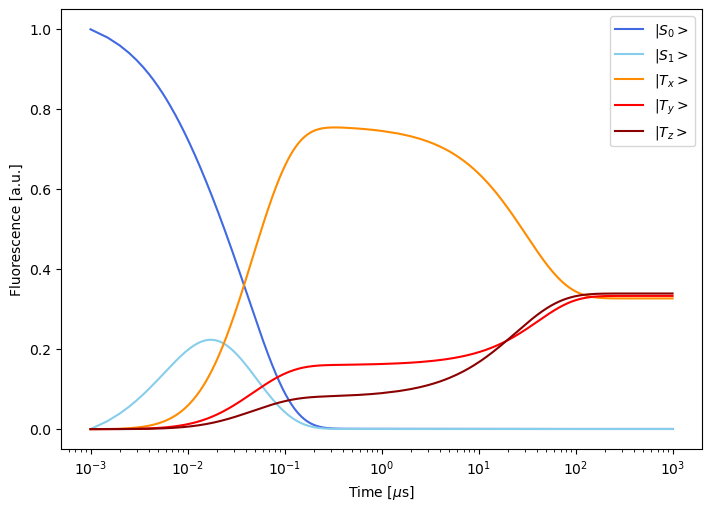

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5), layout = "constrained")
tax = np.concatenate((tax1, tax2))
populations = np.concatenate((populations1, populations2 ))
ax.plot(tax/1e-6, populations[:,0], label = r"$|S_0>$", color = "royalblue")
ax.plot(tax/1e-6, populations[:, 1], label = r"$|S_1>$", color = "skyblue")
ax.plot(tax/1e-6, populations[:, 2], label = r"$|T_x>$", color = "darkorange")
ax.plot(tax/1e-6, populations[:, 3], label = r"$|T_y>$", color = "red")
ax.plot(tax/1e-6, populations[:, 4], label = r"$|T_z>$", color = "darkred")

ax.legend(loc = "upper right")
ax.set_xlabel(r"Time [$\mu$s]")
ax.set_ylabel(r"Fluorescence [a.u.]")
ax.set_xscale("log")


### Part 2: Include coherent Hamiltonian, ODMR simulation 

Set up the static contributions to coherent Hamiltonian and evaluate transition frequencies for various magnetic fields. 

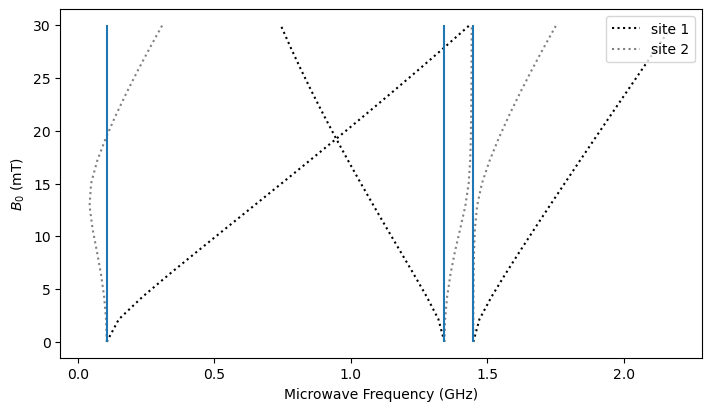

In [ ]:
# effective angles of B fields for two pentacene sites:
theta_1  = np.deg2rad(27)
theta_2 = np.deg2rad(27+60)
phi_1 = np.deg2rad(5)
phi_2 = np.deg2rad(5)
Bmags = np.linspace(0, 30e-3, 15)  # B magnitudes 0 to 30mT
freqs_1 = np.zeros((len(Bmags), 3))
freqs_2 = np.zeros((len(Bmags), 3))

# calculate transition frequencies for the 2 sites for a series of fields 
for ind_B, B in enumerate(Bmags):
    B_1 = sos.spher2cart(B, theta_1, phi_1)
    B_2 = sos.spher2cart(B, theta_2, phi_2)
    H_1 =  HZFS + HZ(B_1[0], B_1[1], B_1[2]) # Hamiltonian for site 1
    H_2 = HZFS + HZ(B_2[0], B_2[1], B_2[2]) # Hamiltonian for site 1
    eigs_1 = H_1.eigenstates()[0]
    eigs_2 = H_2.eigenstates()[0]
    freqs_1[ind_B, :] = [np.abs(eigs_1[3]-eigs_1[2]),np.abs(eigs_1[4]-eigs_1[3]), np.abs(eigs_1[4]-eigs_1[2]) ]
    freqs_2[ind_B, :] = [np.abs(eigs_2[3]-eigs_2[2]),np.abs(eigs_2[4]-eigs_2[3]), np.abs(eigs_2[4]-eigs_2[2]) ]


fig, ax = plt.subplots(1, 1, figsize = (7, 4), layout = "constrained")

ax.plot(sos.w2f(freqs_1[:,0])/1e9, Bmags/1e-3, color = "black", ls = "dotted", label = "site 1")
ax.plot(sos.w2f(freqs_2[:,0])/1e9, Bmags/1e-3, color = "grey", ls = "dotted", label = "site 2")
ax.plot(sos.w2f(freqs_1[:,1])/1e9, Bmags/1e-3, color = "black", ls = "dotted")
ax.plot(sos.w2f(freqs_2[:,1])/1e9, Bmags/1e-3, color = "grey", ls = "dotted")
ax.plot(sos.w2f(freqs_1[:,2])/1e9, Bmags/1e-3, color = "black", ls = "dotted")
ax.plot(sos.w2f(freqs_2[:,2])/1e9, Bmags/1e-3, color = "grey", ls = "dotted")
ax.vlines(0.106, ymin = 0, ymax = 30)
ax.vlines(1.449, ymin = 0, ymax = 30)
ax.vlines(1.343, ymin = 0, ymax = 30)

ax.set_xlabel("Microwave Frequency (GHz)")
ax.set_ylabel(r"$B_0$ (mT)")
ax.legend(loc = "upper right")

Perform a cw ODMR measurement (laboratory frame simulation) for the x,y transition. 

In a first step, we basically repeat our photophysics simulation and just add the coherent dynamics: 
Runtime ca 10 seconds

In [ ]:
# Hamiltonian for mw irradiation
w1 = sos.f2w(5e6) # Rabi frequency
H1 = lambda w0, t, phi : 2*w1*np.cos(w0*t + phi)*(p.Tx + p.Ty + p.Tz) # mw Hamiltonian 
w0 = sos.f2w(0.106e9) #  mw frequency , here we simulate the on-resonance case 
phi  = 0 # phase 

# Build the propagator for a single mw period, define initial states 
period_rf = np.abs(1/sos.w2f(w0)) # duration of a single mw period 
N_rf = 40 # how many steps for one period 
tvec_rf = np.linspace(0, period_rf, N_rf+1) # this is the time vector for one rf period 
dt_rf = tvec_rf[1]-tvec_rf[0] # this is the time step
for n in range(N_rf):
    H = HZFS + H1(w0, tvec_rf[n], phi)
    if n == 0:
        U_rf = sos.evol(H, dt_rf, c_ops = c_ops_on)
        U_norf = sos.evol(0*p.id, dt_rf, c_ops = c_ops_on)
    else: 
        U_rf = sos.evol(H, dt_rf, c_ops = c_ops_on)*U_rf
        U_norf = sos.evol(0*p.id, dt_rf, c_ops = c_ops_on)*U_norf
ttot = 10**(-3) # how long does it take to reach the steady state
pts = int(np.round(ttot/period_rf)) # how many mw periods fit in this time 

populations_rf = np.zeros((pts, len(observables)))
populations_norf = np.zeros((pts, len(observables)))
rho0_rf = p.S0id
rho0_norf = p.S0id

# evolve and measure 
for i in range(pts): # loop over time points 
    # measure 
    for ind_o, o in enumerate(observables):
        populations_rf[i,ind_o ] = np.abs(sos.backends.numpy.expect(o , rho0_rf))  # note one could also call sos.expect directly, however this is currently significantly slower -> will be fixed in next version 
        populations_norf[i,ind_o ] = np.abs(sos.backends.numpy.expect(o , rho0_norf))
    # evolve 
    rho0_rf = sos.backends.numpy.applySuperoperator(U_rf,rho0_rf)
    rho0_norf = sos.backends.numpy.applySuperoperator(U_norf,rho0_norf)


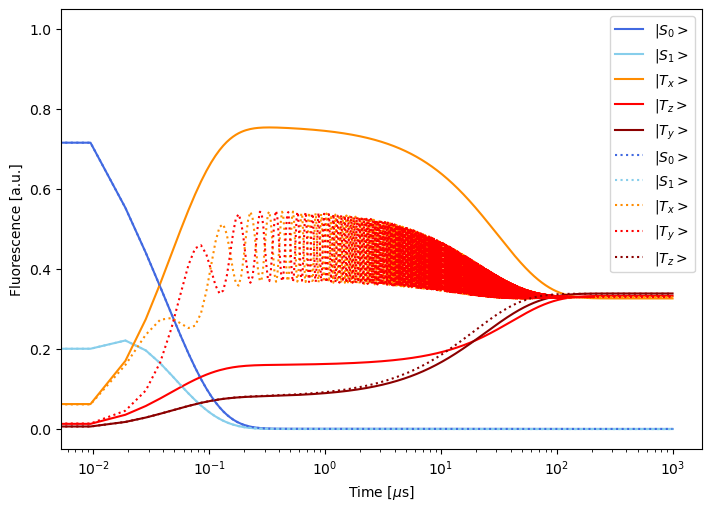

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5), layout = "constrained")

tax = np.linspace(0, pts*period_rf, pts)
ax.plot(tax/1e-6, populations_norf[:,0], label = r"$|S_0>$", color = "royalblue")
ax.plot( tax/1e-6, populations_norf[:, 1], label = r"$|S_1>$", color = "skyblue")
ax.plot( tax/1e-6, populations_norf[:, 2], label = r"$|T_x>$", color = "darkorange")
ax.plot(tax/1e-6, populations_norf[:, 3], label = r"$|T_z>$", color = "red")
ax.plot( tax/1e-6,populations_norf[:, 4], label = r"$|T_y>$", color = "darkred")
ax.plot( tax/1e-6,populations_rf[:,0], label = r"$|S_0>$", color = "royalblue", ls = "dotted")
ax.plot( tax/1e-6,populations_rf[:, 1], label = r"$|S_1>$", color = "skyblue", ls = "dotted")
ax.plot( tax/1e-6,populations_rf[:, 2], label = r"$|T_x>$", color = "darkorange", ls = "dotted")
ax.plot( tax/1e-6,populations_rf[:, 3], label = r"$|T_y>$", color = "red", ls = "dotted")
ax.plot(tax/1e-6,populations_rf[:, 4], label = r"$|T_z>$", color = "darkred", ls = "dotted")

ax.legend(loc = "upper right")
ax.set_xlabel(r"Time [$\mu$s]")
ax.set_ylabel(r"Fluorescence [a.u.]")
ax.set_xscale("log")
#plt.plot(luminesencetm)

We calculate the cw ODMR contrast from the population difference of the S1 state (that is proportional to the photoluminescence).

In [ ]:
np.abs(populations_rf[-1][1]-populations_norf[-1][1])/populations_norf[-1][1]

0.006614528295294799

Finally, we simulate the ODMR contrast as a function of frequency.
Runtime ca 10 seconds

In [ ]:
# Build the propagator for a single rf period 
w1 = sos.f2w(5e6) # Rabi frequency
wax =  np.linspace(sos.f2w(0.09e9), sos.f2w(0.125e9), 15)
N_rf = 40
pts = 60000
c_ODMR = []
for w0 in wax:
    # Build propagator 
    period_rf = np.abs(1/sos.w2f(w0))
    tvec_rf = np.linspace(0, period_rf, N_rf+1)
    dt_rf = tvec_rf[1]-tvec_rf[0]
    for n in range(N_rf):
        H = HZFS + H1(w0, tvec_rf[n], phi)
        if n == 0:
            U_rf = sos.evol(H, dt_rf, c_ops = c_ops_on)
            U_norf = sos.evol(0*p.id, dt_rf, c_ops = c_ops_on)
        else: 
            U_rf = sos.evol(H, dt_rf, c_ops = c_ops_on)*U_rf
            U_norf = sos.evol(0*p.id, dt_rf, c_ops = c_ops_on)*U_norf
    # Initialise 
    rho0_rf = p.S0id
    rho0_norf = p.S0id
    # Propagate
    for i in range(pts):
        rho0_rf = sos.backends.numpy.applySuperoperator(U_rf,rho0_rf)
        rho0_norf = sos.backends.numpy.applySuperoperator(U_norf,rho0_norf)
    fluorescence_rf = sos.backends.numpy.expect(p.S1id, rho0_rf)
    fluorescence_norf = sos.backends.numpy.expect(p.S1id, rho0_norf)
    c_ODMR.append(np.abs(fluorescence_rf-fluorescence_norf)/fluorescence_norf)

Text(0, 0.5, 'ODMR contrast')

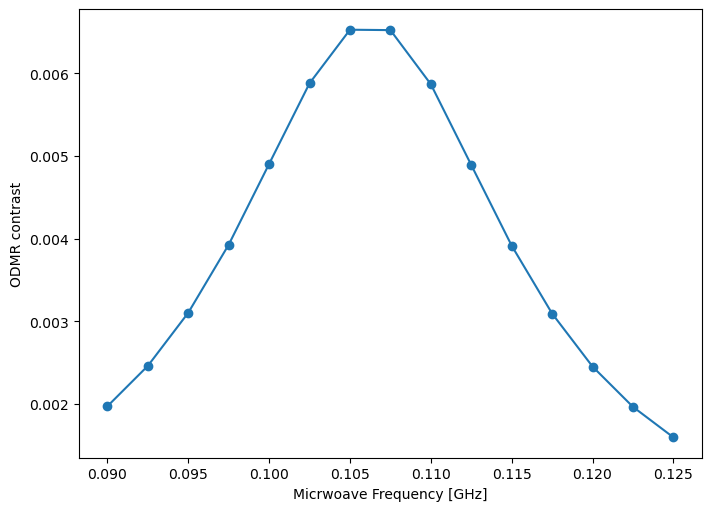

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5), layout = "constrained")

ax.plot(sos.w2f(wax)/1e9, c_ODMR, "-o")
ax.set_xlabel(r"Micrwoave Frequency [GHz]")
ax.set_ylabel(r"ODMR contrast")

$$